In [1]:
pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.5 MB/s eta 0:00:00


In [2]:
pip install "gymnasium[box2d]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379370 sha256=a17d55630c7a9bfcd1f32806733266168e107c41fdbca2c6dddb878b28afe04c
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py



Training on LunarLander-v3...


<ipython-input-3-4e2cb999429c>:144: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states_tensor = torch.FloatTensor(states)


Thread 0 | Episode 0 | Reward: -63.371283884352
Thread 1 | Episode 0 | Reward: -124.993543913677
Thread 0 | Episode 1 | Reward: -101.16779843730646
Thread 1 | Episode 1 | Reward: -205.85051908438277
Thread 0 | Episode 2 | Reward: -199.0367773132012
Thread 1 | Episode 2 | Reward: -109.15767509298296
Thread 0 | Episode 3 | Reward: -223.20993774221685
Thread 1 | Episode 3 | Reward: -200.53638665825238
Thread 0 | Episode 4 | Reward: -137.02719056890797
Thread 1 | Episode 4 | Reward: -75.78346263468607
Thread 0 | Episode 5 | Reward: -406.551578518688
Thread 1 | Episode 5 | Reward: -53.464344890724654
Thread 1 | Episode 6 | Reward: -89.5739049108923
Thread 0 | Episode 6 | Reward: -122.86154290477103
Thread 0 | Episode 7 | Reward: -144.37800444201082
Thread 1 | Episode 7 | Reward: -89.77787352588571
Thread 0 | Episode 8 | Reward: -261.54212007267904
Thread 1 | Episode 8 | Reward: -49.86339633619503
Thread 0 | Episode 9 | Reward: -102.4889044512673
Thread 0 | Episode 10 | Reward: -402.13064499

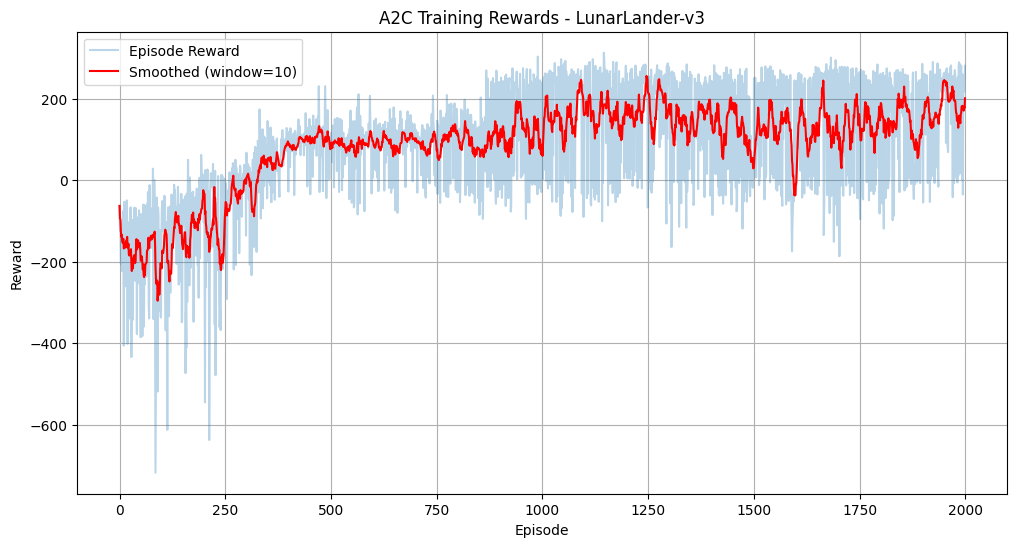

Evaluation results for LunarLander-v3: Mean reward = 170.21


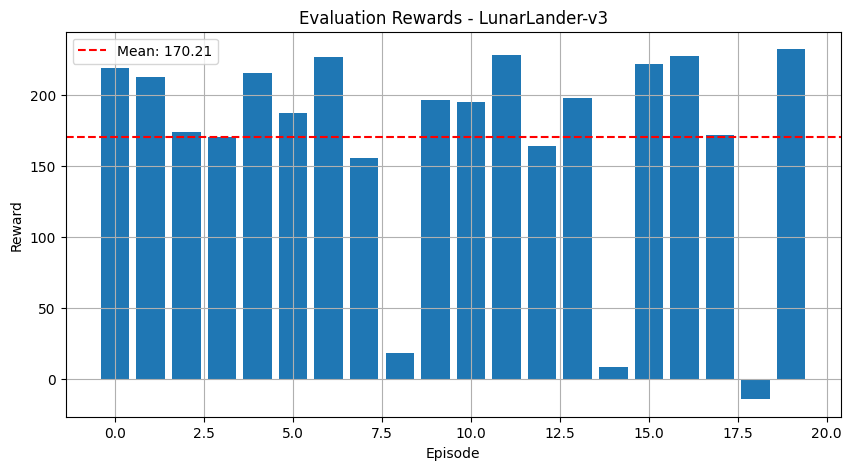

In [3]:
import os
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread, Lock
import time

REWARD_SCALE = 0.01

class A2CNetwork(nn.Module):
    def __init__(self, input_dim, action_dim, is_continuous=False):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
        )
        self.is_continuous = is_continuous
        if is_continuous:
            self.mean_layer = nn.Linear(256, action_dim)
            self.log_std = nn.Parameter(torch.zeros(action_dim))
        else:
            self.policy = nn.Linear(256, action_dim)
        self.value = nn.Linear(256, 1)

    def forward(self, x):
        x = self.shared(x)
        if self.is_continuous:
            mean = self.mean_layer(x)
            std = torch.exp(self.log_std)
            return mean, std, self.value(x)
        else:
            return self.policy(x), self.value(x)


class RunningMeanStd:
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.count = epsilon
        self.epsilon = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        delta = batch_mean - self.mean
        tot_count = self.count + batch_count
        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / tot_count
        new_var = M2 / tot_count
        self.mean, self.var, self.count = new_mean, new_var, tot_count

    def normalize(self, x):
        return (x - self.mean) / np.sqrt(self.var + self.epsilon)


def compute_gae(rewards, values, next_value, dones, gamma=0.99, lam=0.95):
    gae = 0
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * (next_value if i == len(rewards) - 1 else values[i+1]) * (1 - dones[i]) - values[i]
        gae = delta + gamma * lam * (1 - dones[i]) * gae
        returns.insert(0, gae + values[i])
    return torch.FloatTensor(returns)



def a2c_worker(env_name, global_model, optimizer, queue, thread_id, state_normalizer,
               model_lock, normalizer_lock, episodes_per_thread=375,
               gamma=0.99, entropy_coef=0.01, is_continuous=False):
    env = gym.make(env_name)
    episode_rewards = []

    for episode in range(episodes_per_thread):
        state, _ = env.reset()
        done = False
        states, actions, rewards, values, dones = [], [], [], [], []
        episode_states = []
        total_reward = 0

        while not done:
            episode_states.append(state.copy())
            with normalizer_lock:
                norm_state = state_normalizer.normalize(state)

            state_tensor = torch.FloatTensor(norm_state).unsqueeze(0)

            with model_lock:
                if is_continuous:
                    mean, std, value = global_model(state_tensor)
                    dist = torch.distributions.Normal(mean, std)
                    action = dist.sample()
                    action_clipped = torch.clamp(action, torch.tensor(env.action_space.low), torch.tensor(env.action_space.high))
                    action_env = action_clipped.squeeze(0).numpy()
                else:
                    logits, value = global_model(state_tensor)
                    dist = torch.distributions.Categorical(logits=logits)
                    action = dist.sample()
                    action_env = action.item()

            next_state, reward, terminated, truncated, _ = env.step(action_env)
            reward *= REWARD_SCALE
            done = terminated or truncated

            rewards.append(reward)
            states.append(norm_state)
            actions.append(action_env if is_continuous else action)
            values.append(value.item())
            dones.append(1.0 if done else 0.0)

            total_reward += reward
            state = next_state

        with normalizer_lock:
            state_normalizer.update(np.array(episode_states))

        with normalizer_lock:
            norm_next_state = state_normalizer.normalize(state)

        next_state_tensor = torch.FloatTensor(norm_next_state).unsqueeze(0)

        with model_lock:
            if is_continuous:
                _, _, next_value = global_model(next_state_tensor)
            else:
                _, next_value = global_model(next_state_tensor)
            next_value = next_value.item()

        returns = compute_gae(rewards, values, next_value, dones, gamma)
        advantages = returns - torch.FloatTensor(values)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        states_tensor = torch.FloatTensor(states)
        actions_tensor = torch.FloatTensor(actions) if is_continuous else torch.LongTensor(actions)

        with model_lock:
            if is_continuous:
                means, stds, values_pred = global_model(states_tensor)
                dist = torch.distributions.Normal(means, stds)
                log_probs = dist.log_prob(actions_tensor).sum(dim=-1)
                entropy = dist.entropy().sum(dim=-1).mean()
            else:
                logits, values_pred = global_model(states_tensor)
                dist = torch.distributions.Categorical(logits=logits)
                log_probs = dist.log_prob(actions_tensor)
                entropy = dist.entropy().mean()

            actor_loss = -(log_probs * advantages).mean()
            critic_loss = 0.5 * (values_pred.squeeze() - returns).pow(2).mean()
            loss = actor_loss + critic_loss - entropy_coef * entropy

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(global_model.parameters(), 0.5)
            optimizer.step()

        episode_rewards.append(total_reward / REWARD_SCALE)
        queue.put((thread_id, episode, total_reward / REWARD_SCALE))

    env.close()
    return episode_rewards


def train_multithreaded(env_name, total_episodes=1500, num_threads=2,
                        learning_rate=0.0003, gamma=0.99, entropy_coef=0.01,
                        save_path=None):
    torch.manual_seed(42)
    np.random.seed(42)
    env = gym.make(env_name)
    input_dim = env.observation_space.shape[0]
    is_continuous = isinstance(env.action_space, gym.spaces.Box)
    action_dim = env.action_space.shape[0] if is_continuous else env.action_space.n
    env.close()

    state_normalizer = RunningMeanStd(shape=(input_dim,))
    global_model = A2CNetwork(input_dim, action_dim, is_continuous)
    global_model.share_memory()
    optimizer = optim.Adam(global_model.parameters(), lr=learning_rate)

    queue = Queue()
    threads = []
    all_rewards = []
    model_lock = Lock()
    normalizer_lock = Lock()
    episodes_per_thread = total_episodes // num_threads

    for thread_id in range(num_threads):
        thread = Thread(target=a2c_worker,
                        args=(env_name, global_model, optimizer, queue, thread_id,
                              state_normalizer, model_lock, normalizer_lock,
                              episodes_per_thread, gamma, entropy_coef, is_continuous))
        threads.append(thread)
        thread.start()

    for _ in range(total_episodes):
        thread_id, episode, reward = queue.get()
        print(f"Thread {thread_id} | Episode {episode} | Reward: {reward}")
        all_rewards.append(reward)

    for thread in threads:
        thread.join()

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save({
            'model_state_dict': global_model.state_dict(),
            'normalizer_mean': state_normalizer.mean,
            'normalizer_var': state_normalizer.var,
            'normalizer_count': state_normalizer.count,
        }, save_path)
        print(f"\nModel saved {save_path}")

    return all_rewards, global_model, state_normalizer


def evaluate_model(env_name, model, state_normalizer, num_episodes=20):
    env = gym.make(env_name, render_mode=None)
    is_continuous = isinstance(env.action_space, gym.spaces.Box)
    rewards = []

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            norm_state = state_normalizer.normalize(state)
            state_tensor = torch.FloatTensor(norm_state).unsqueeze(0)
            with torch.no_grad():
                if is_continuous:
                    mean, _, _ = model(state_tensor)
                    action = torch.clamp(mean, torch.tensor(env.action_space.low), torch.tensor(env.action_space.high))
                    action_env = action.squeeze(0).numpy()
                else:
                    logits, _ = model(state_tensor)
                    action_env = torch.argmax(logits, dim=1).item()
            state, reward, terminated, truncated, _ = env.step(action_env)
            done = terminated or truncated
            total_reward += reward
        rewards.append(total_reward)
    env.close()
    return rewards


def plot_rewards(rewards, env_name, window=10):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, alpha=0.3, label='Episode Reward')
    if len(rewards) > window:
        smooth_rewards = [np.mean(rewards[max(0,i-window):i+1]) for i in range(len(rewards))]
        plt.plot(smooth_rewards, color='red', label=f'Smoothed (window={window})')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'A2C Training Rewards - {env_name}')
    plt.grid(True)
    plt.legend()
    plt.show()


def run_for_env(env_name, total_episodes=1500, save_model_as='saved_models/a2c_model.pth'):
    print(f"\nTraining on {env_name}...")
    rewards, model, normalizer = train_multithreaded(env_name, total_episodes=total_episodes, save_path=save_model_as)
    plot_rewards(rewards, env_name)
    eval_rewards = evaluate_model(env_name, model, normalizer, num_episodes=20)
    print(f"Evaluation results for {env_name}: Mean reward = {np.mean(eval_rewards):.2f}")
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(eval_rewards)), eval_rewards)
    plt.axhline(np.mean(eval_rewards), color='red', linestyle='--', label=f'Mean: {np.mean(eval_rewards):.2f}')
    plt.title(f'Evaluation Rewards - {env_name}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    run_for_env("LunarLander-v3", total_episodes=2000)
